### Importing Necessary Libraries

In [67]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization, Concatenate
# from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [68]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [69]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [70]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [71]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [72]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [73]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

We have already generated the Extracted Feature Vectors from the ResNet Model now we train using that, so we load those feature vectors.

In [78]:
fine_tune_data_resnet = np.load('./Data/ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_resnet.shape

(16000, 5, 2048)

In [79]:
fine_tune_data_vgg = np.load('./Data/VGG16-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_vgg.shape

(16000, 5, 512)

In [80]:
fine_tune_data_inception_resnet = np.load('./Data/Inception-ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_inception_resnet.shape

(16000, 5, 1536)

In [32]:
# fine_tune_data = np.concatenate([fine_tune_data_resnet, fine_tune_data_vgg, fine_tune_data_inception_resnet], axis=-1)
# fine_tune_data.shape

(16000, 1536)

In [81]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [82]:
fine_tune_data_resnet_train = fine_tune_data_resnet[list(train_labels['id'])]
fine_tune_data_resnet_train.shape

(15200, 5, 2048)

In [83]:
fine_tune_data_vgg_train = fine_tune_data_vgg[list(train_labels['id'])]
fine_tune_data_vgg_train.shape

(15200, 5, 512)

In [84]:
fine_tune_data_inception_resnet_train = fine_tune_data_inception_resnet[list(train_labels['id'])]
fine_tune_data_inception_resnet_train.shape

(15200, 5, 1536)

In [35]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [85]:
fine_tune_data_resnet_test = fine_tune_data_resnet[list(test_labels['id'])]
fine_tune_data_resnet_test.shape

(800, 5, 2048)

In [86]:
fine_tune_data_vgg_test = fine_tune_data_vgg[list(test_labels['id'])]
fine_tune_data_vgg_test.shape

(800, 5, 512)

In [87]:
fine_tune_data_inception_resnet_test = fine_tune_data_inception_resnet[list(test_labels['id'])]
fine_tune_data_inception_resnet_test.shape

(800, 5, 1536)

In [88]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

## Fine-Tuning Models

The fine-tuning part of our model.

In [89]:
def ftmodel():
    inputs1 = Input(shape=(5, 2048))
    inputs2 = Input(shape=(5, 512))
    inputs3 = Input(shape=(5, 1536))

    top_dropout_rate = 0.5
    
    x = Flatten()(inputs1)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate)(x)
    x = Dense(512, kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    
    y = Flatten()(inputs2)
    y = BatchNormalization()(y)
    y = Dropout(top_dropout_rate)(y)
    y = Dense(512, kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(y)
    
    z = Flatten()(inputs3)
    z = BatchNormalization()(z)
    z = Dropout(top_dropout_rate)(z)
    z = Dense(512, kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(z)
    
    a = Concatenate()([x, y, z])
    
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    a = Dropout(top_dropout_rate)(a)
    a = Dense(512, kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(a)
    a = BatchNormalization()(a)
    
    a = Dropout(top_dropout_rate)(a)
    # x = Dense(256, name='top_dense_3', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dropout(top_dropout_rate, name='top_dropout_4')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(a)

    model1 = tf.keras.Model([inputs1, inputs2, inputs3], outputs, name='RestNet-VGG-Inception-ResNet-FineTune')
    return model1

In [90]:
model1 = ftmodel()
model1.summary()

Model: "RestNet-VGG-Inception-ResNet-FineTune"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 5, 2048)]    0           []                               
                                                                                                  
 flatten_10 (Flatten)           (None, 10240)        0           ['input_11[0][0]']               
                                                                                                  
 input_12 (InputLayer)          [(None, 5, 512)]     0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 5, 1536)]    0           []                               
                                                              

In [91]:
# tf.keras.utils.plot_model(model1, show_shapes=True, to_file='./Images/ResNet-VGG-Inception-ResNet-4Piece-PCA-Model.png')

### Model Training

In [92]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [93]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/ResNet-VGG-Inception-4Piece-Indiv-Concat/auto-ResNet-VGG-Inception-ResNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [94]:
history = model1.fit([fine_tune_data_resnet_train, fine_tune_data_vgg_train, fine_tune_data_inception_resnet_train], fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=([fine_tune_data_resnet_test, fine_tune_data_vgg_test, fine_tune_data_inception_resnet_test], fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/ResNet-VGG-Inception-4Piece-Indiv-Concat/resnet-vgg-inception-resnet-4p-model-weights")
model1.load_weights('./Models/ResNet-VGG-Inception-4Piece-Indiv-Concat/resnet-vgg-inception-resnet-4p-model-weights')

Epoch 1/1000


2022-10-09 17:56:49.492498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/19 [===========================>..] - ETA: 0s - loss: 2.6925 - accuracy: 0.3557

2022-10-09 17:56:50.765168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 2s 70ms/step - loss: 2.6650 - accuracy: 0.3615 - val_loss: 2.1840 - val_accuracy: 0.3725
Epoch 2/1000
19/19 [==============================] - 1s 57ms/step - loss: 1.9439 - accuracy: 0.5116 - val_loss: 1.8921 - val_accuracy: 0.5025
Epoch 3/1000
19/19 [==============================] - 1s 48ms/step - loss: 1.7399 - accuracy: 0.5618 - val_loss: 1.8229 - val_accuracy: 0.5375
Epoch 4/1000
19/19 [==============================] - 1s 49ms/step - loss: 1.5852 - accuracy: 0.6024 - val_loss: 1.7414 - val_accuracy: 0.5737
Epoch 5/1000
19/19 [==============================] - 1s 50ms/step - loss: 1.4732 - accuracy: 0.6289 - val_loss: 1.6793 - val_accuracy: 0.5938
Epoch 6/1000
19/19 [==============================] - 1s 47ms/step - loss: 1.3657 - accuracy: 0.6555 - val_loss: 1.6296 - val_accuracy: 0.5950
Epoch 7/1000
19/19 [==============================] - 1s 46ms/step - loss: 1.2854 - accuracy: 0.6810 - val_loss: 1.5629 - val_accuracy: 0.6250
Epoch 8/1000

19/19 [==============================] - 1s 47ms/step - loss: 0.3137 - accuracy: 0.9653 - val_loss: 1.1528 - val_accuracy: 0.7788
Epoch 59/1000
19/19 [==============================] - 1s 51ms/step - loss: 0.3117 - accuracy: 0.9666 - val_loss: 1.1521 - val_accuracy: 0.7788
Epoch 60/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.3136 - accuracy: 0.9629 - val_loss: 1.1438 - val_accuracy: 0.7900
Epoch 61/1000
19/19 [==============================] - 1s 48ms/step - loss: 0.3061 - accuracy: 0.9682 - val_loss: 1.1414 - val_accuracy: 0.7912
Epoch 62/1000
19/19 [==============================] - 1s 50ms/step - loss: 0.3051 - accuracy: 0.9674 - val_loss: 1.1653 - val_accuracy: 0.7900
Epoch 63/1000
19/19 [==============================] - 1s 48ms/step - loss: 0.3039 - accuracy: 0.9671 - val_loss: 1.1552 - val_accuracy: 0.7825
Epoch 64/1000
19/19 [==============================] - 1s 48ms/step - loss: 0.3038 - accuracy: 0.9685 - val_loss: 1.1495 - val_accuracy: 0.7900
Epoch 

Epoch 115/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.2404 - accuracy: 0.9860 - val_loss: 1.2619 - val_accuracy: 0.7925
Epoch 116/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.2441 - accuracy: 0.9849 - val_loss: 1.2455 - val_accuracy: 0.7937
Epoch 117/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.2396 - accuracy: 0.9858 - val_loss: 1.2249 - val_accuracy: 0.7875
Epoch 118/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.2398 - accuracy: 0.9859 - val_loss: 1.2453 - val_accuracy: 0.7950
Epoch 119/1000
19/19 [==============================] - 1s 49ms/step - loss: 0.2378 - accuracy: 0.9859 - val_loss: 1.2408 - val_accuracy: 0.7875
Epoch 120/1000
19/19 [==============================] - 1s 46ms/step - loss: 0.2346 - accuracy: 0.9859 - val_loss: 1.2620 - val_accuracy: 0.7962
Epoch 121/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.2364 - accuracy: 0.9861 - val_loss: 1.2546 - val_ac

19/19 [==============================] - 0s 25ms/step - loss: 0.2186 - accuracy: 0.9882 - val_loss: 1.2957 - val_accuracy: 0.8025
Epoch 172/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.2144 - accuracy: 0.9891 - val_loss: 1.2862 - val_accuracy: 0.7975
Epoch 173/1000
19/19 [==============================] - 1s 25ms/step - loss: 0.2198 - accuracy: 0.9881 - val_loss: 1.3067 - val_accuracy: 0.8025
Epoch 174/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.2188 - accuracy: 0.9874 - val_loss: 1.3967 - val_accuracy: 0.7837
Epoch 175/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.2137 - accuracy: 0.9884 - val_loss: 1.3141 - val_accuracy: 0.8000
Epoch 176/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.2158 - accuracy: 0.9888 - val_loss: 1.3059 - val_accuracy: 0.7925
Epoch 177/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.2179 - accuracy: 0.9875 - val_loss: 1.3317 - val_accuracy: 0.7887


19/19 [==============================] - 1s 31ms/step - loss: 0.1970 - accuracy: 0.9911 - val_loss: 1.4003 - val_accuracy: 0.7912
Epoch 228/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.1940 - accuracy: 0.9923 - val_loss: 1.3259 - val_accuracy: 0.7937
Epoch 229/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1966 - accuracy: 0.9920 - val_loss: 1.3600 - val_accuracy: 0.7912
Epoch 230/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.1947 - accuracy: 0.9918 - val_loss: 1.3246 - val_accuracy: 0.7975
Epoch 231/1000
19/19 [==============================] - 1s 25ms/step - loss: 0.1969 - accuracy: 0.9909 - val_loss: 1.2996 - val_accuracy: 0.8000
Epoch 232/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.1978 - accuracy: 0.9901 - val_loss: 1.3246 - val_accuracy: 0.8025
Epoch 233/1000
19/19 [==============================] - 1s 47ms/step - loss: 0.1937 - accuracy: 0.9912 - val_loss: 1.3698 - val_accuracy: 0.8025


19/19 [==============================] - 1s 49ms/step - loss: 0.1824 - accuracy: 0.9921 - val_loss: 1.4396 - val_accuracy: 0.8025
Epoch 284/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1848 - accuracy: 0.9920 - val_loss: 1.4059 - val_accuracy: 0.7962
Epoch 285/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.1834 - accuracy: 0.9924 - val_loss: 1.3571 - val_accuracy: 0.8062
Epoch 286/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.1836 - accuracy: 0.9914 - val_loss: 1.3566 - val_accuracy: 0.8012
Epoch 287/1000
19/19 [==============================] - 1s 51ms/step - loss: 0.1811 - accuracy: 0.9925 - val_loss: 1.3814 - val_accuracy: 0.8112
Epoch 288/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.1918 - accuracy: 0.9887 - val_loss: 1.3536 - val_accuracy: 0.8012
Epoch 289/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1820 - accuracy: 0.9924 - val_loss: 1.3608 - val_accuracy: 0.7975


19/19 [==============================] - 1s 48ms/step - loss: 0.1731 - accuracy: 0.9933 - val_loss: 1.3027 - val_accuracy: 0.7900
Epoch 340/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1789 - accuracy: 0.9913 - val_loss: 1.3242 - val_accuracy: 0.8012
Epoch 341/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1821 - accuracy: 0.9903 - val_loss: 1.3767 - val_accuracy: 0.7862
Epoch 342/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.1767 - accuracy: 0.9914 - val_loss: 1.3620 - val_accuracy: 0.7950
Epoch 343/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1754 - accuracy: 0.9925 - val_loss: 1.3541 - val_accuracy: 0.8087
Epoch 344/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1777 - accuracy: 0.9916 - val_loss: 1.3636 - val_accuracy: 0.8012
Epoch 345/1000
19/19 [==============================] - 1s 24ms/step - loss: 0.1766 - accuracy: 0.9922 - val_loss: 1.3397 - val_accuracy: 0.8000


19/19 [==============================] - 1s 29ms/step - loss: 0.1672 - accuracy: 0.9934 - val_loss: 1.4022 - val_accuracy: 0.7837
Epoch 396/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1653 - accuracy: 0.9930 - val_loss: 1.4017 - val_accuracy: 0.7862
Epoch 397/1000
19/19 [==============================] - 1s 46ms/step - loss: 0.1623 - accuracy: 0.9941 - val_loss: 1.3832 - val_accuracy: 0.7825
Epoch 398/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.1667 - accuracy: 0.9918 - val_loss: 1.3714 - val_accuracy: 0.7887
Epoch 399/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1671 - accuracy: 0.9930 - val_loss: 1.4522 - val_accuracy: 0.7825
Epoch 400/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.1654 - accuracy: 0.9926 - val_loss: 1.4097 - val_accuracy: 0.7962
Epoch 401/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.1656 - accuracy: 0.9929 - val_loss: 1.4267 - val_accuracy: 0.7975


19/19 [==============================] - 1s 47ms/step - loss: 0.1570 - accuracy: 0.9940 - val_loss: 1.3403 - val_accuracy: 0.8050
Epoch 452/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1613 - accuracy: 0.9920 - val_loss: 1.3263 - val_accuracy: 0.8012
Epoch 453/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.1578 - accuracy: 0.9939 - val_loss: 1.3153 - val_accuracy: 0.7900
Epoch 454/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1583 - accuracy: 0.9940 - val_loss: 1.3807 - val_accuracy: 0.7987
Epoch 455/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.1605 - accuracy: 0.9932 - val_loss: 1.3743 - val_accuracy: 0.8037
Epoch 456/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1573 - accuracy: 0.9941 - val_loss: 1.4084 - val_accuracy: 0.7912
Epoch 457/1000
19/19 [==============================] - 1s 25ms/step - loss: 0.1621 - accuracy: 0.9925 - val_loss: 1.3734 - val_accuracy: 0.8050


19/19 [==============================] - 1s 28ms/step - loss: 0.1587 - accuracy: 0.9928 - val_loss: 1.3848 - val_accuracy: 0.7987
Epoch 508/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.1551 - accuracy: 0.9938 - val_loss: 1.3905 - val_accuracy: 0.8000
Epoch 509/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.1570 - accuracy: 0.9932 - val_loss: 1.3949 - val_accuracy: 0.8037
Epoch 510/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.1574 - accuracy: 0.9938 - val_loss: 1.3991 - val_accuracy: 0.7912
Epoch 511/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.1551 - accuracy: 0.9928 - val_loss: 1.3728 - val_accuracy: 0.7962
Epoch 512/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.1583 - accuracy: 0.9926 - val_loss: 1.3536 - val_accuracy: 0.8075
Epoch 513/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.1566 - accuracy: 0.9924 - val_loss: 1.3769 - val_accuracy: 0.8062


19/19 [==============================] - 1s 29ms/step - loss: 0.1526 - accuracy: 0.9934 - val_loss: 1.3595 - val_accuracy: 0.8037
Epoch 564/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.1517 - accuracy: 0.9930 - val_loss: 1.3813 - val_accuracy: 0.8000
Epoch 565/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.1550 - accuracy: 0.9930 - val_loss: 1.3685 - val_accuracy: 0.7950
Epoch 566/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.1513 - accuracy: 0.9936 - val_loss: 1.3706 - val_accuracy: 0.7962
Epoch 567/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.1520 - accuracy: 0.9932 - val_loss: 1.3781 - val_accuracy: 0.8025
Epoch 568/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.1529 - accuracy: 0.9926 - val_loss: 1.4063 - val_accuracy: 0.7900
Epoch 569/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.1543 - accuracy: 0.9927 - val_loss: 1.3791 - val_accuracy: 0.7950


19/19 [==============================] - 0s 25ms/step - loss: 0.1512 - accuracy: 0.9928 - val_loss: 1.2814 - val_accuracy: 0.8087
Epoch 620/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.1532 - accuracy: 0.9930 - val_loss: 1.2563 - val_accuracy: 0.8100
Epoch 621/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.1500 - accuracy: 0.9938 - val_loss: 1.2587 - val_accuracy: 0.8087
Epoch 622/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.1504 - accuracy: 0.9934 - val_loss: 1.3210 - val_accuracy: 0.7937
Epoch 623/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.1524 - accuracy: 0.9935 - val_loss: 1.3037 - val_accuracy: 0.8000
Epoch 624/1000
19/19 [==============================] - 1s 50ms/step - loss: 0.1470 - accuracy: 0.9946 - val_loss: 1.3234 - val_accuracy: 0.8037
Epoch 625/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.1477 - accuracy: 0.9942 - val_loss: 1.3097 - val_accuracy: 0.8000


19/19 [==============================] - 0s 25ms/step - loss: 0.1473 - accuracy: 0.9938 - val_loss: 1.3410 - val_accuracy: 0.8000
Epoch 676/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.1466 - accuracy: 0.9931 - val_loss: 1.3328 - val_accuracy: 0.8025
Epoch 677/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1496 - accuracy: 0.9934 - val_loss: 1.3316 - val_accuracy: 0.8025
Epoch 678/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1469 - accuracy: 0.9936 - val_loss: 1.3276 - val_accuracy: 0.8000
Epoch 679/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1488 - accuracy: 0.9932 - val_loss: 1.2886 - val_accuracy: 0.8037
Epoch 680/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.1483 - accuracy: 0.9930 - val_loss: 1.2841 - val_accuracy: 0.7987
Epoch 681/1000
19/19 [==============================] - 1s 47ms/step - loss: 0.1445 - accuracy: 0.9944 - val_loss: 1.3221 - val_accuracy: 0.8012


19/19 [==============================] - 0s 26ms/step - loss: 0.1439 - accuracy: 0.9947 - val_loss: 1.3244 - val_accuracy: 0.7950
Epoch 732/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1454 - accuracy: 0.9936 - val_loss: 1.3159 - val_accuracy: 0.7975
Epoch 733/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.1428 - accuracy: 0.9941 - val_loss: 1.3083 - val_accuracy: 0.7912
Epoch 734/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1450 - accuracy: 0.9934 - val_loss: 1.3420 - val_accuracy: 0.7912
Epoch 735/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.1423 - accuracy: 0.9946 - val_loss: 1.3307 - val_accuracy: 0.7900
Epoch 736/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1442 - accuracy: 0.9938 - val_loss: 1.3800 - val_accuracy: 0.7887
Epoch 737/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.1420 - accuracy: 0.9948 - val_loss: 1.3599 - val_accuracy: 0.7987


19/19 [==============================] - 1s 29ms/step - loss: 0.1453 - accuracy: 0.9936 - val_loss: 1.3070 - val_accuracy: 0.8000
Epoch 788/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.1414 - accuracy: 0.9950 - val_loss: 1.3410 - val_accuracy: 0.7925
Epoch 789/1000
19/19 [==============================] - 1s 47ms/step - loss: 0.1403 - accuracy: 0.9950 - val_loss: 1.3171 - val_accuracy: 0.8037
Epoch 790/1000
19/19 [==============================] - 1s 25ms/step - loss: 0.1406 - accuracy: 0.9947 - val_loss: 1.3077 - val_accuracy: 0.8025
Epoch 791/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1420 - accuracy: 0.9939 - val_loss: 1.2813 - val_accuracy: 0.7950
Epoch 792/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.1413 - accuracy: 0.9945 - val_loss: 1.2939 - val_accuracy: 0.8025
Epoch 793/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1434 - accuracy: 0.9935 - val_loss: 1.2907 - val_accuracy: 0.8000


19/19 [==============================] - 0s 25ms/step - loss: 0.1396 - accuracy: 0.9947 - val_loss: 1.3989 - val_accuracy: 0.7937
Epoch 844/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1388 - accuracy: 0.9950 - val_loss: 1.3903 - val_accuracy: 0.7812
Epoch 845/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1418 - accuracy: 0.9936 - val_loss: 1.3428 - val_accuracy: 0.7962
Epoch 846/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1404 - accuracy: 0.9938 - val_loss: 1.3122 - val_accuracy: 0.7950
Epoch 847/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1388 - accuracy: 0.9949 - val_loss: 1.3223 - val_accuracy: 0.7950
Epoch 848/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1405 - accuracy: 0.9939 - val_loss: 1.3473 - val_accuracy: 0.7900
Epoch 849/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1378 - accuracy: 0.9953 - val_loss: 1.3341 - val_accuracy: 0.7912


19/19 [==============================] - 0s 25ms/step - loss: 0.1381 - accuracy: 0.9945 - val_loss: 1.3316 - val_accuracy: 0.8012
Epoch 900/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1389 - accuracy: 0.9946 - val_loss: 1.3286 - val_accuracy: 0.7962
Epoch 901/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.1390 - accuracy: 0.9945 - val_loss: 1.3595 - val_accuracy: 0.7912
Epoch 902/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1377 - accuracy: 0.9945 - val_loss: 1.4145 - val_accuracy: 0.7950
Epoch 903/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.1379 - accuracy: 0.9940 - val_loss: 1.3403 - val_accuracy: 0.7912
Epoch 904/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.1366 - accuracy: 0.9947 - val_loss: 1.3455 - val_accuracy: 0.7900
Epoch 905/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1386 - accuracy: 0.9946 - val_loss: 1.3698 - val_accuracy: 0.7887


19/19 [==============================] - 0s 25ms/step - loss: 0.1383 - accuracy: 0.9942 - val_loss: 1.3361 - val_accuracy: 0.8025
Epoch 956/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.1380 - accuracy: 0.9947 - val_loss: 1.3159 - val_accuracy: 0.8025
Epoch 957/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.1364 - accuracy: 0.9941 - val_loss: 1.3068 - val_accuracy: 0.7962
Epoch 958/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1408 - accuracy: 0.9938 - val_loss: 1.3115 - val_accuracy: 0.7912
Epoch 959/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.1372 - accuracy: 0.9945 - val_loss: 1.3246 - val_accuracy: 0.7950
Epoch 960/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.1372 - accuracy: 0.9949 - val_loss: 1.3388 - val_accuracy: 0.7975
Epoch 961/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1380 - accuracy: 0.9939 - val_loss: 1.3616 - val_accuracy: 0.7912


In [95]:
model1.load_weights('./Models/ResNet-VGG-Inception-4Piece-Indiv-Concat/auto-ResNet-VGG-Inception-ResNet-FT-model-weight')

In [96]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

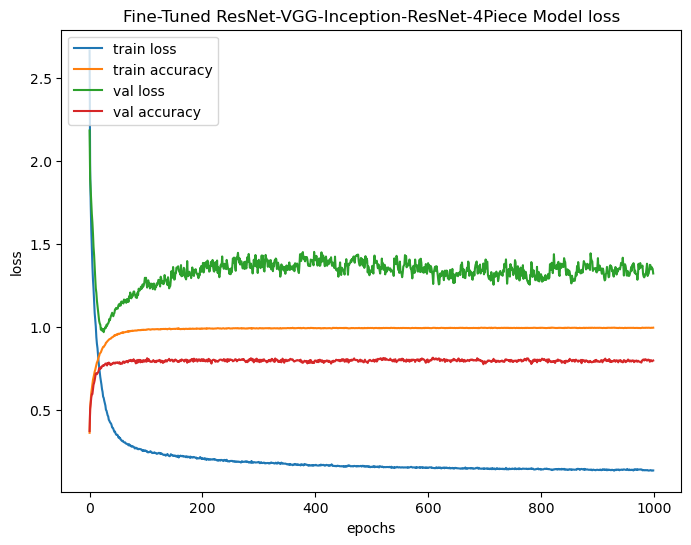

In [97]:
plot_train_loss(history, 'Fine-Tuned ResNet-VGG-Inception-ResNet-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [98]:
train_preds = model1.predict([fine_tune_data_resnet_train, fine_tune_data_vgg_train, fine_tune_data_inception_resnet_train])

 26/475 [>.............................] - ETA: 1s

2022-10-09 18:07:15.867983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 2s 4ms/step


In [99]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [100]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [101]:
np.sum(train_pred_labels == train_labels['label'])

15197

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [102]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
3597,3781,./Data/train/train/3781.tif,0
12255,12896,./Data/train/train/12896.tif,9
14569,15333,./Data/train/train/15333.tif,7


In [52]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,1.000000,0.998978,0.999488,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [103]:
test_preds = model1.predict([fine_tune_data_resnet_test, fine_tune_data_vgg_test, fine_tune_data_inception_resnet_test])

25/25 [==============================] - 0s 5ms/step


In [104]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [105]:
test_pred_labels

array([11,  8,  6,  7, 10,  6, 13, 12, 14,  1,  6, 15,  7, 14,  1, 11,  0,
        9,  6, 12,  8, 14,  3, 12,  6,  0,  3,  8,  3,  3, 11,  1,  9,  2,
        1,  8,  4,  7,  1,  9,  6, 12, 14,  2,  5, 14,  3,  0, 13,  4,  0,
       10, 12, 15, 11, 14, 15,  6,  9,  2, 15, 13, 11, 11,  6,  8,  8,  0,
        6,  3,  4,  4, 12,  0,  8,  6,  7,  0, 12, 11, 11, 15, 12, 12,  9,
        8,  1, 13, 13,  0, 10, 11,  4, 10,  1,  7, 11,  8, 13, 10,  3, 10,
        5,  9,  7, 14,  8,  2,  1,  5,  7,  5,  9,  4, 12, 12, 12,  1, 11,
        6, 13,  1,  0, 12,  1, 10, 12,  4, 15, 11,  3, 11,  6,  1,  6,  9,
       14, 10,  7, 14, 10,  8, 11, 12,  8, 10,  8,  9,  2, 13, 15, 14,  4,
       14,  4,  9,  4, 14,  7, 11,  8,  4,  4, 10, 13,  8, 15,  3,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 11, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13, 12, 10, 11, 11, 11,  1,  9,  1,
        9,  5, 13, 14, 12,  1,  4,  8, 11,  6, 13,  5,  4, 12,  8,  0,  9,
        1, 15,  0,  7,  5

In [106]:
np.sum(test_pred_labels == test_labels['label'])

634

In [57]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
5,67,./Data/train/train/67.tif,9
7,100,./Data/train/train/100.tif,10
19,372,./Data/train/train/372.tif,13
...,...,...,...
769,15453,./Data/train/train/15453.tif,14
776,15528,./Data/train/train/15528.tif,5
779,15568,./Data/train/train/15568.tif,9
785,15621,./Data/train/train/15621.tif,15


In [58]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.816327,0.740741,0.776699,54
1,0.638298,0.681818,0.659341,44
2,0.974359,0.883721,0.926829,43
3,0.843137,0.934783,0.886598,46
4,0.853659,0.972222,0.909091,36
5,0.756757,0.560000,0.643678,50
6,0.836735,0.891304,0.863158,46
7,0.846154,0.846154,0.846154,52
8,0.828125,0.981481,0.898305,54
9,0.844444,0.808511,0.826087,47


In [59]:
np.mean(fscore)

0.8123396122618025

#### On Validation Data

Generating Predictions for the Validation Set

In [60]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [270]:
fine_tune_data_validation_resnet = np.load('./Data/ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_resnet.shape

(900, 5, 2048)

In [271]:
fine_tune_data_validation_vgg = np.load('./Data/VGG16-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_vgg.shape

(900, 5, 512)

In [272]:
fine_tune_data_validation_inception_resnet = np.load('./Data/Inception-ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_inception_resnet.shape

(900, 5, 1536)

In [273]:
fine_tune_data_validation_red_resnet = np.zeros((fine_tune_data_validation_resnet.shape[0], 5, N_COMPS_1))
for i in range(5):
    fine_tune_data_validation_red_resnet[:,i,:] = pcas_resnet[i].transform(fine_tune_data_validation_resnet[:,i,:])
fine_tune_data_validation_resnet = fine_tune_data_validation_red_resnet
del fine_tune_data_validation_red_resnet
fine_tune_data_validation_resnet.shape

(900, 5, 1300)

In [274]:
fine_tune_data_validation_red_vgg = np.zeros((fine_tune_data_validation_vgg.shape[0], 5, N_COMPS_2))
for i in range(5):
    fine_tune_data_validation_red_vgg[:,i,:] = pcas_vgg[i].transform(fine_tune_data_validation_vgg[:,i,:])
fine_tune_data_validation_vgg = fine_tune_data_validation_red_vgg
del fine_tune_data_validation_red_vgg
fine_tune_data_validation_vgg.shape

(900, 5, 300)

In [275]:
fine_tune_data_validation_red_inception_resnet = np.zeros((fine_tune_data_validation_inception_resnet.shape[0], 5, N_COMPS_3))
for i in range(5):
    fine_tune_data_validation_red_inception_resnet[:,i,:] = pcas_inception_resnet[i].transform(fine_tune_data_validation_inception_resnet[:,i,:])
fine_tune_data_validation_inception_resnet = fine_tune_data_validation_red_inception_resnet
del fine_tune_data_validation_red_inception_resnet
fine_tune_data_validation_inception_resnet.shape

(900, 5, 900)

In [276]:
fine_tune_data_validation = np.concatenate([fine_tune_data_validation_resnet, fine_tune_data_validation_vgg, fine_tune_data_validation_inception_resnet], axis=-1)
fine_tune_data_validation.shape

(900, 5, 2500)

In [277]:
valid_preds = model1.predict(fine_tune_data_validation)

29/29 [==============================] - 0s 3ms/step


2022-10-09 15:57:30.272902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [278]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [279]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,8
898,18699,10


In [280]:
submission_data.to_csv('./Submissions/submission-resnet-vgg-inception-4p.csv', index=False)